In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings

In [47]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load data
try:
    train_df = pd.read_excel("Data_Train.xlsx")
    test_df = pd.read_excel("Test_set.xlsx")
except FileNotFoundError:
    print("Error: Make sure 'Data_Train.xlsx' and 'Test_set.xlsx' are in the same directory.")
    exit()

train_df.dropna(inplace=True)

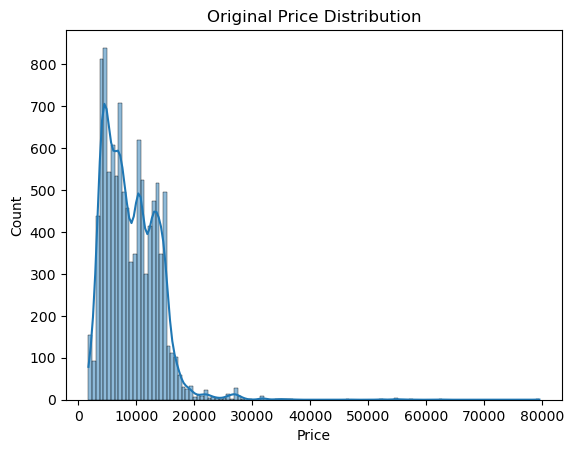

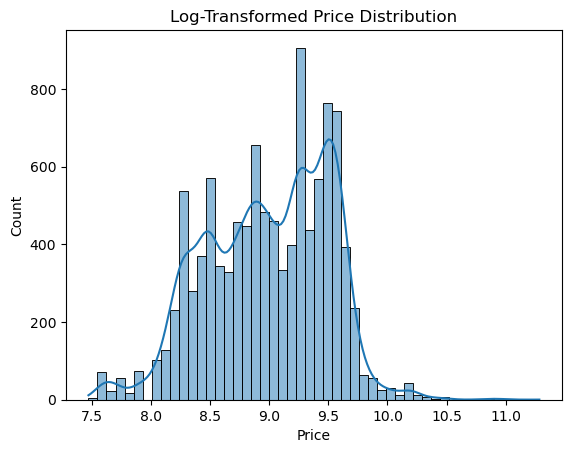

In [48]:
# EDA 
sns.histplot(train_df['Price'], kde=True)
plt.title("Original Price Distribution")
plt.show()

sns.histplot(np.log1p(train_df['Price']), kde=True)
plt.title('Log-Transformed Price Distribution')
plt.show()

In [49]:
# 3. Duration
def convert_duration_to_minutes(duration_str):
    duration_str = str(duration_str) # Ensure it's a string
    hours, minutes = 0, 0
    if 'h' in duration_str:
        parts = duration_str.split('h')
        hours = int(parts[0])
        if 'm' in parts[1]:
            minutes = int(parts[1].replace('m', '').strip())
    elif 'm' in duration_str:
        minutes = int(duration_str.replace('m', ''))
    
    # Handle rare cases like '5m' which appeared in test set in some versions
    if 'h' not in duration_str and 'm' not in duration_str:
         try:
             # Check if it's just a number, assume minutes
             minutes = int(duration_str)
         except ValueError:
             pass # Keep as 0 if not convertible
             
    return hours * 60 + minutes

In [50]:
# --- custom evaluation metric ---
def calculate_custom_metric(y_true, y_pred):
    """
    Calculates the metric: 1 - RMSLE (base 10)
    """
    # Ensure predictions are non-negative
    y_pred = np.maximum(y_pred, 0)
    
    # 1. Apply log10(y + 1) transform
    log_true = np.log10(y_true + 1)
    log_pred = np.log10(y_pred + 1)
    
    # 2. Calculate Mean Squared Error on the log-transformed data
    mse_log10 = mean_squared_error(log_true, log_pred)
    
    # 3. Take the square root to get RMSLE (base 10)
    rmsle_10 = np.sqrt(mse_log10)
    
    # 4. Calculate the final score
    score = 1 - rmsle_10
    return score

In [51]:
# Combine train and test for consistent preprocessing
full_df = pd.concat([train_df.drop('Price', axis=1), test_df], ignore_index=True)

# 1. Date_of_Journey
full_df['Date_of_Journey'] = pd.to_datetime(full_df['Date_of_Journey'], format='%d/%m/%Y')
full_df['journey_day'] = full_df['Date_of_Journey'].dt.day
full_df['journey_month'] = full_df['Date_of_Journey'].dt.month
full_df.drop('Date_of_Journey', axis=1, inplace=True)

# 2. Dep_Time and Arrival_Time
full_df['dep_hour'] = pd.to_datetime(full_df['Dep_Time'], format='%H:%M').dt.hour
full_df['dep_min'] = pd.to_datetime(full_df['Dep_Time'], format='%H:%M').dt.minute
full_df.drop('Dep_Time', axis=1, inplace=True)

# Handle varied Arrival_Time formats (some may not have ' ' space)
full_df['Arrival_Time'] = full_df['Arrival_Time'].astype(str)
arrival_time_only = full_df['Arrival_Time'].apply(lambda x: x.split(' ')[0])
full_df['arrival_hour'] = pd.to_datetime(arrival_time_only, format='%H:%M').dt.hour
full_df['arrival_min'] = pd.to_datetime(arrival_time_only, format='%H:%M').dt.minute
full_df.drop('Arrival_Time', axis=1, inplace=True)
full_df['duration_mins'] = full_df['Duration'].apply(convert_duration_to_minutes)
full_df.drop('Duration', axis=1, inplace=True)

# 4. Total_Stops
stop_mapping = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
# Use fillna(1) as a default (e.g., for 1 stop) if any NaN values exist
full_df['Total_Stops'] = full_df['Total_Stops'].map(stop_mapping).fillna(1) 
full_df['Total_Stops'] = full_df['Total_Stops'].astype(int)

# 5. Categorical features
full_df = pd.get_dummies(full_df, columns=['Airline', 'Source', 'Destination'], drop_first=True)

# 6. Drop redundant columns
full_df.drop(['Route', 'Additional_Info'], axis=1, inplace=True)

# --- Preprocessing Done ---

In [52]:
# Split back into train and test
X = full_df.iloc[:len(train_df)]
X_test_final = full_df.iloc[len(train_df):]
y = np.log1p(train_df['Price'])

# Split train-validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# --- Model 1: Random Forest ---
print("Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=2)
rf.fit(X_train, y_train)
print("Random Forest trained.")

Training Random Forest...
Random Forest trained.


In [54]:
# --- Model 2: XGBoost ---
print("\nTraining XGBoost...")
xgbr = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse',
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

xgbr.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False  # Set to True if you want to see training logs
)
print("XGBoost trained.")


Training XGBoost...
XGBoost trained.


In [58]:
# --- Model Evaluation (Updated) ---
print("\n--- Model Comparison ---")

# Get actual (non-log) validation prices
y_val_actual = np.expm1(y_val)

# 1. Evaluate Random Forest
val_preds_rf_log = rf.predict(X_val)
val_preds_actual_rf = np.expm1(val_preds_rf_log)
score_rf = calculate_custom_metric(y_val_actual, val_preds_actual_rf)
print(f"Random Forest Custom Metric (1 - RMSLE10): {score_rf:.4f}")

# 2. Evaluate XGBoost
val_preds_xgb_log = xgbr.predict(X_val)
val_preds_actual_xgb = np.expm1(val_preds_xgb_log)
score_xgb = calculate_custom_metric(y_val_actual, val_preds_actual_xgb)
print(f"XGBoost Custom Metric (1 - RMSLE10): {score_xgb:.4f}")


--- Model Comparison ---
Random Forest Custom Metric (1 - RMSLE10): 0.9241
XGBoost Custom Metric (1 - RMSLE10): 0.9287



--- Final Results ---
Choosing XGBoost as the best model.
Displaying visualization for the best model...


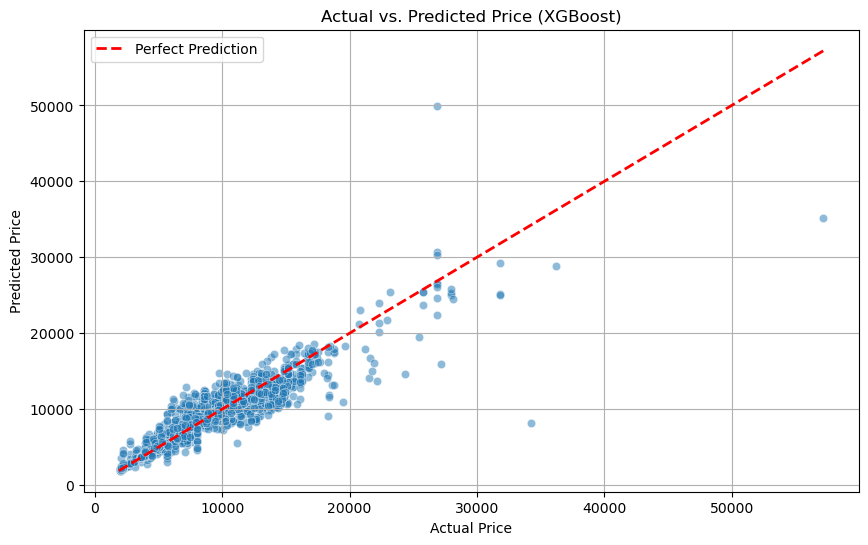

Submission file 'submission.csv' created successfully.


In [61]:
# --- Final Submission & Visualization Setup ---
print("\n--- Final Results ---")
best_model = None
best_preds_actual = None
model_name = ""

if score_rf > score_xgb:
    print("Choosing Random Forest as the best model.")
    best_model = rf
    best_preds_actual = val_preds_actual_rf
    model_name = "Random Forest"
else:
    print("Choosing XGBoost as the best model.")
    best_model = xgbr
    best_preds_actual = val_preds_actual_xgb
    model_name = "XGBoost"
# --- NEW: Final Visualization ---

print("Displaying visualization for the best model...")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_actual, y=best_preds_actual, alpha=0.5)

# Add a 45-degree line (perfect prediction)
max_price = max(y_val_actual.max(), best_preds_actual.max())
min_price = min(y_val_actual.min(), best_preds_actual.min())
plt.plot([min_price, max_price], [min_price, max_price], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs. Predicted Price ({model_name})")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------

# Predict on test set and create submission file
test_preds_log = best_model.predict(X_test_final)
test_preds_actual = np.expm1(test_preds_log)
test_preds_actual = np.maximum(test_preds_actual, 0) # Ensure no negative prices

submission = pd.DataFrame({
    'Price': test_preds_actual
})

submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")